In [1]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "tensorflow.compat.v1"
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf"

# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

In [2]:
import tensorflow.compat.v1 as tf

import deepxde as dde
import numpy as np
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pylab
from numpy import linalg as LA
import math
import scipy.io
from os.path import dirname, join as pjoin
from scipy.stats import truncnorm, norm
# import tensorflow as tf
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    
if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2022-09-08 18:04:00.355202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 18:04:00.363997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 18:04:00.364352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
N = nSample = 100

# must be floats
state_min = 0.0
state_max = 6.0

mu_0 = 5.0
sigma_0 = 1.0

mu_T = 4.0
sigma_T = 1.0

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

id_prefix = "small_example"

print(time.time())

1662685449.2895672


In [6]:
def boundary(_, on_initial):
    return on_initial

def pdf1d_T(x):
    a, b = (state_min - mu_T) / sigma_T, (state_max - mu_T) / sigma_T
    rho_x=truncnorm.pdf(x, a, b, loc = mu_0, scale = sigma_0)

#     rho_x = norm.pdf(x, mu_T, sigma_T)
    return rho_x

def pdf1d_0(x):
    a, b = (state_min - mu_0) / sigma_0, (state_max - mu_0) / sigma_0
    rho_x=truncnorm.pdf(x, a, b, loc = mu_0, scale = sigma_0)

#     rho_x = norm.pdf(x, mu_0, sigma_0)
    return rho_x

print(time.time())

1662685456.229663


In [7]:
rv0 = multivariate_normal([mu_0, mu_0, mu_0], sigma_0 * np.eye(3))
rvT = multivariate_normal([mu_T, mu_T, mu_T], sigma_T * np.eye(3))

def pdf3d_0(x,y,z):
    return rv0.pdf(np.hstack((x, y, z)))

def pdf3d_T(x,y,z):
    return rvT.pdf(np.hstack((x, y, z)))

print(time.time())

1662685458.139784


In [8]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)
print(time.time())

1662685459.2713


In [9]:
# 3d linprog example, with bounds

rho_0=pdf3d_0(x_T,y_T,z_T).reshape(len(x_T),1)
rho_T=pdf3d_T(x_T,y_T,z_T).reshape(len(x_T),1)

# very important to make it solvable
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(rho_0)

rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(rho_T)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print("mu_0 %.3f to mu_T %.3f" % (mu_0, mu_T))
    print(np.sqrt(res.fun))

Running HiGHS 1.2.2 [date: 2022-08-30, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
148 rows, 5412 cols, 10824 nonzeros
148 rows, 5412 cols, 10824 nonzeros
Presolve : Reductions: rows 148(-52); columns 5412(-4588); elements 10824(-9176)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 148(2) 0s
       1567     9.1142070175e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
       1567     9.1142000096e-01 Pr: 1(1.7578e-07) 0s
       1609     9.1142104026e-01 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1609
Objective value     :  9.1142104026e-01
HiGHS run time      :          0.05
mu_0 5.000 to mu_T 4.000
0.9546837383441185


In [10]:
# 1d linprog example

rho_0_1d=pdf1d_0(x_T).reshape(len(x_T),1)
rho_T_1d=pdf1d_T(x_T).reshape(len(x_T),1)

rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)
rho_0_1d = rho_0_1d / np.sum(np.abs(rho_0_1d))

# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)[0]
# rho_0_1d = rho_0_1d / rho_0_1d_trapz
# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)
# print("rho_0_1d_trapz=",rho_0_1d_trapz)

print(rho_0_1d)

rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)

rho_T_1d = rho_T_1d / np.sum(np.abs(rho_T_1d))

# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)[0]
# rho_T_1d = rho_T_1d / rho_T_1d_trapz
# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)
# print("rho_T_1d_trapz=",rho_T_1d_trapz)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0_1d, rho_T_1d), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print("mu_0 %.3f to mu_T %.3f" % (mu_0, mu_T))
    print(res.fun, np.sqrt(res.fun))

[[0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.002]
 [0.002]
 [0.002]
 [0.002]
 [0.003]
 [0.003]
 [0.004]
 [0.004]
 [0.005]
 [0.005]
 [0.006]
 [0.006]
 [0.007]
 [0.008]
 [0.009]
 [0.009]
 [0.01 ]
 [0.011]
 [0.012]
 [0.013]
 [0.014]
 [0.015]
 [0.016]
 [0.017]
 [0.018]
 [0.019]
 [0.02 ]
 [0.021]
 [0.022]
 [0.023]
 [0.024]
 [0.025]
 [0.026]
 [0.026]
 [0.027]
 [0.027]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.027]
 [0.027]
 [0.026]
 [0.026]
 [0.025]
 [0.024]
 [0.023]
 [0.022]
 [0.021]
 [0.02 ]
 [0.019]
 [0.018]
 [0.017]]
Running HiGHS 1.2.2 [date: 2022-08-30, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licenc

In [ ]:
# def modify_output(X, Y):
#     y1, y2, y3  = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3]
#     u_new = tf.clip_by_value(y3, clip_value_min = .5, clip_value_max = 4)
#     return tf.concat((y1, y2, u_new), axis=1)

In [12]:
S3 = dde.Variable(1.0)
a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005
K, T=1.38066*10**-23, 293.

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here
    Including a penalty function for negative solutions
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
#     dD2_x=dde.grad.jacobian(D2, x, j=0)
#     dF_x=dde.grad.jacobian(F, x, j=0)
#     D1=dD2_x-dF_x*(D2/(K*T))
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100

    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
#         neg_loss,
#         neg_loss_y2,
    ]


print(time.time())

1662685479.9183366


In [13]:
def penalty(xpdf):
    p1 = 10 * (xpdf<0).sum()
    
    t = np.trapz(xpdf, axis=0)[0]
    p2 = 10 * np.abs(t - 1)
    return p1 + p2

def WASS(y_true, y_pred):
    xpdf = y_pred.numpy()

    xpdf = np.where(xpdf < 0, 0, xpdf)
    if np.sum(xpdf) > 1e-8:
        xpdf = xpdf / np.sum(xpdf)

    res = linprog(
        cvector,
        A_eq=A,
        b_eq=np.concatenate((xpdf, rho_0_1d), axis=0),
        options={"disp": False},
        bounds=[(0, np.inf)],
    )
    
    # we are cheating here, we are using tf.reduce_sum
    # so that tf system will like our output 'type'
    # but we are 0'ing the sum and adding our scalar cost
    cand = tf.reduce_sum(y_pred) * 0.0
    
    if res.fun is None:
        return np.inf + cand
    else:
        lin = np.sqrt(res.fun)
        pen = penalty(xpdf)
#         print("trapz %.3f, count %d, pen %.3f, lin %.3f" % (
#             np.trapz(xpdf, axis=0)[0],
#             (xpdf<0).sum(),
#             pen,
#             lin))
        return lin + cand + pen

def WASS2(y_true, y_pred):
    loss = tf.py_function(
        func=WASS,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

def Z(y_true, y_pred):
#     xpdf = y_pred.numpy()
    
#     t = np.trapz(xpdf, axis=0)[0]
#     p2 = 10 * np.abs(t - 1)
    
    cand = tf.abs(-5/6 - tf.reduce_sum(y_pred))
    
    # if minimum is negative, this is increased
    # so it is incentivized to be positive
    cand = cand + 50 * (0 - tf.reduce_min(y_pred))

    return cand

def Z2(y_true, y_pred):
    loss = tf.py_function(
        func=Z,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

print(time.time())

1662685502.8006024


In [14]:
geom = dde.geometry.Interval(state_min, state_max)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

print(time.time())

1662685505.7206872


In [15]:
time_0=np.hstack((x_T,T_0*np.ones((len(x_T), 1))))
rho_0=pdf1d_0(x_T).reshape(len(x_T),1)
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(np.abs(rho_0))
print(np.trapz(rho_0, axis=0)[0])
print(np.sum(rho_0))
rho_0_BC = dde.icbc.PointSetBC(time_0, rho_0, component=1)

time_t=np.hstack((x_T,T_t*np.ones((len(x_T), 1))))
rho_T=pdf1d_T(x_T).reshape(len(x_T),1)
rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(np.abs(rho_T))
print(np.trapz(rho_T, axis=0)[0])
print(np.sum(rho_T))
rho_T_BC = dde.icbc.PointSetBC(time_t, rho_T, component=1)

print(time.time())

0.9913593372441998
1.0
0.99135907115671
1.0000000000000002
1662685507.710654


In [16]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [rho_0_BC,rho_T_BC],
    num_domain=5000,
    num_initial=500)

# 2 inputs: x + t
# 3 outputs: 3 eqs
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
# net.apply_output_transform(modify_output)
# net.apply_output_transform(modify_output)
model = dde.Model(data, net)

print(time.time())

1662685510.2424085


In [17]:
ck_path = "%s/%s_model" % (os.path.abspath("./"), id_prefix)

class EarlyStoppingFixed(dde.callbacks.EarlyStopping):
    def on_epoch_end(self):
        current = self.get_monitor_value()
        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            # must meet baseline first
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = self.model.train_state.epoch
                self.model.stop_training = True
        else:
            self.wait = 0
                
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch))
        
        self.model.save(ck_path, verbose=True)

earlystop_cb = EarlyStoppingFixed(baseline=1e-3, patience=0)

print(time.time())

1662685512.403448


In [18]:
loss_func=["MSE","MSE","MSE", Z2, "MSE"]
# loss functions are based on PDE + BC: 3 eq outputs, 2 BCs

model.compile("adam", lr=1e-3,loss=loss_func)
losshistory, train_state = model.train(
    epochs=50000,
    display_every=1000,
    callbacks=[earlystop_cb])

Compiling model...
Building feed-forward neural network...
'build' took 0.022561 s



/usr/local/home/cyan3/miniforge/envs/tf/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/usr/local/home/cyan3/miniforge/envs/tf/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-09-08 18:05:18.191895: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 18:05:18.192509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA n

Tensor("Sum:0", shape=(), dtype=float32)
Tensor("Sum_1:0", shape=(), dtype=float32)
Tensor("Sum_2:0", shape=(), dtype=float32)
Tensor("Sum_3:0", shape=(), dtype=float32)
Tensor("Sum_4:0", shape=(), dtype=float32)
Tensor("Sum_5:0", shape=(), dtype=float32)
Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
'compile' took 1.738026 s

Initializing variables...
Training model...



2022-09-08 18:05:20.128870: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2022-09-08 18:05:20.570099: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-08 18:05:20.571295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 18:05:20.571509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 18:05:20.571660: I tensorflo

Step      Train loss                                            Test loss                                             Test metric
0         [1.47e-01, 6.50e-04, 6.85e-01, 3.50e+01, 1.41e-01]    [1.47e-01, 6.50e-04, 6.85e-01, 3.50e+01, 1.41e-01]    []  


2022-09-08 18:05:21.570139: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2022-09-08 18:05:21.577570: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


1000      [4.19e-06, 1.11e-05, 7.91e-05, 4.12e+00, 1.17e-04]    [4.19e-06, 1.11e-05, 7.91e-05, 4.12e+00, 1.17e-04]    []  
2000      [1.27e-06, 6.19e-06, 5.52e-05, 3.15e+00, 1.12e-04]    [1.27e-06, 6.19e-06, 5.52e-05, 3.15e+00, 1.12e-04]    []  
3000      [6.65e-07, 3.28e-06, 2.21e-05, 1.25e+00, 2.55e-04]    [6.65e-07, 3.28e-06, 2.21e-05, 1.25e+00, 2.55e-04]    []  
4000      [6.80e-07, 2.79e-06, 4.41e-05, 9.72e-01, 8.40e-05]    [6.80e-07, 2.79e-06, 4.41e-05, 9.72e-01, 8.40e-05]    []  
5000      [2.33e-07, 1.33e-06, 1.52e-05, 8.68e-01, 7.99e-05]    [2.33e-07, 1.33e-06, 1.52e-05, 8.68e-01, 7.99e-05]    []  
6000      [1.38e-07, 5.62e-07, 5.31e-06, 6.23e-01, 1.16e-04]    [1.38e-07, 5.62e-07, 5.31e-06, 6.23e-01, 1.16e-04]    []  
7000      [1.08e-07, 1.19e-06, 5.40e-06, 5.77e-01, 6.66e-05]    [1.08e-07, 1.19e-06, 5.40e-06, 5.77e-01, 6.66e-05]    []  
8000      [2.54e-07, 8.91e-07, 2.97e-06, 7.03e-01, 9.01e-05]    [2.54e-07, 8.91e-07, 2.97e-06, 7.03e-01, 9.01e-05]    []  
9000      [6.59e

Saving loss history to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/loss.dat ...
Saving training data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/train.dat ...
Saving test data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/test.dat ...


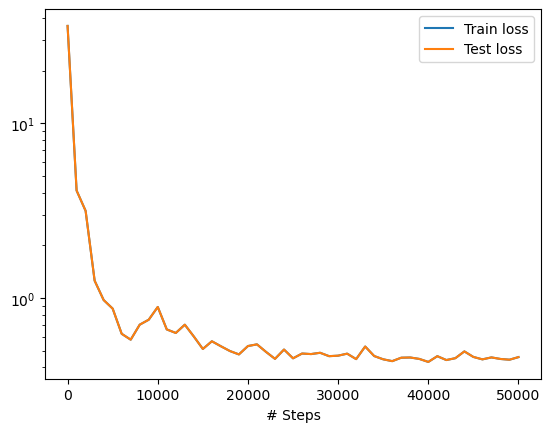

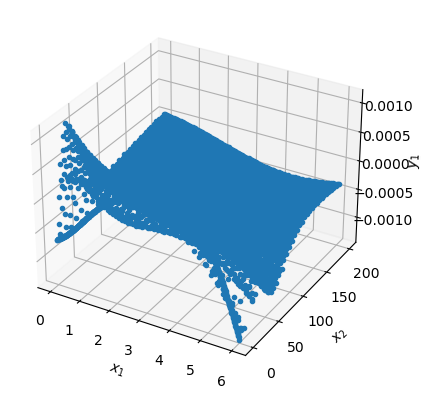

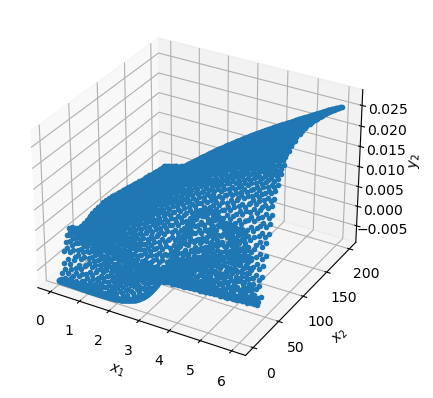

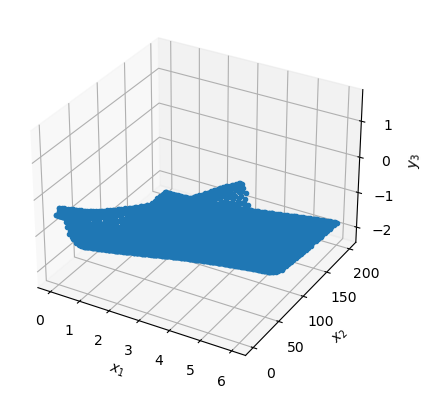

INFO:tensorflow:/usr/local/home/cyan3/Dev/jim/gradschool/231/research/small_example_model-50000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
/usr/local/home/cyan3/Dev/jim/gradschool/231/research/small_example_model-50000.ckpt


In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
model_path = model.save(ck_path)
print(model_path)

In [20]:
params = {'backend': 'ps',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.handlelength': 1,
          'legend.borderaxespad': 0,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
plt.style.use('seaborn-white')

loss_loaded [[    0.        0.147     0.001     0.685    35.031     0.141     0.147     0.001     0.685    35.031     0.141]
 [ 1000.        0.        0.        0.        4.116     0.        0.        0.        0.        4.116     0.   ]
 [ 2000.        0.        0.        0.        3.149     0.        0.        0.        0.        3.149     0.   ]
 [ 3000.        0.        0.        0.        1.255     0.        0.        0.        0.        1.255     0.   ]
 [ 4000.        0.        0.        0.        0.972     0.        0.        0.        0.        0.972     0.   ]
 [ 5000.        0.        0.        0.        0.868     0.        0.        0.        0.        0.868     0.   ]
 [ 6000.        0.        0.        0.        0.623     0.        0.        0.        0.        0.623     0.   ]
 [ 7000.        0.        0.        0.        0.577     0.        0.        0.        0.        0.577     0.   ]
 [ 8000.        0.        0.        0.        0.703     0.        0.        0.      

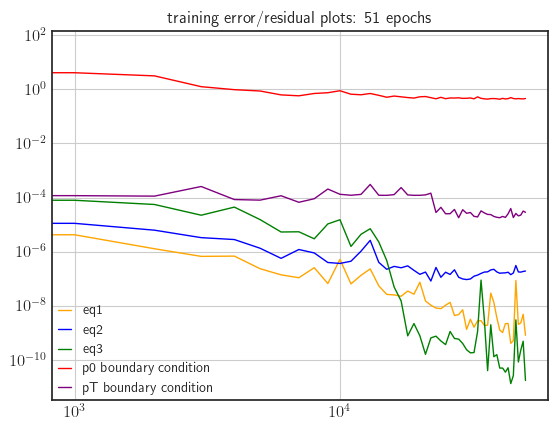

In [21]:
# 16 plot loss

loss_loaded = np.genfromtxt('./loss.dat')

print("loss_loaded", loss_loaded)

# import ipdb; ipdb.set_trace();

# [0] epoch
# [1] y1, psi, hjb
# [2] y2, rho, plank pde
# [3] rho0, initial
# [4] rhoT, terminal

epoch = loss_loaded[:, 0]
y1_psi_hjb = loss_loaded[:, 1]
y2_rho_plankpde = loss_loaded[:, 2]
loss3 = loss_loaded[:, 3]
rho0_initial = loss_loaded[:, 4]
rhoT_terminal = loss_loaded[:, 5]

fig, ax = plt.subplots()


line1, = ax.plot(epoch, y1_psi_hjb, color='orange', lw=1, label='eq1')
line2, = ax.plot(epoch, y2_rho_plankpde, color='blue', lw=1, label='eq2')
line2, = ax.plot(epoch, loss3, color='green', lw=1, label='eq3')
line3, = ax.plot(epoch, rho0_initial, color='red', lw=1, label='p0 boundary condition')
line4, = ax.plot(epoch, rhoT_terminal, color='purple', lw=1, label='pT boundary condition')

ax.grid()
ax.legend(loc="lower left")
ax.set_title('training error/residual plots: %d epochs' % (len(epoch)))
ax.set_yscale('log')
ax.set_xscale('log')

plot_fname = "%s/loss.png" % (os.path.abspath("./"))
plt.savefig(plot_fname, dpi=300)
print("saved plot")

plt.show()

In [22]:
T_IDX = 1
EQ_IDX = 3

In [23]:
# 18 load test data

test = np.genfromtxt('./test.dat')
# test_timesorted = test[test[:, 3].argsort()]
# sort AGAIN by output because a lot of samples @ t=0, t=5
ind = np.lexsort((test[:,EQ_IDX],test[:,T_IDX])) # sorts by [1] (t) then by [3] (rho_0)
test_timesorted = test[ind]
source_t = test_timesorted[:, 1]

print(test_timesorted)

[[  1.266   0.      0.     -0.008  -0.481]
 [  1.254   0.     -0.     -0.008  -0.481]
 [  1.273   0.      0.     -0.008  -0.481]
 ...
 [  5.879 200.     -0.      0.025  -1.802]
 [  5.939 200.     -0.      0.025  -1.795]
 [  6.    200.     -0.      0.025  -1.789]]


[[ 0.     0.    -0.001 -0.008 -0.466]
 [ 5.262  0.    -0.     0.019  1.422]
 [ 0.387  0.    -0.001 -0.008 -0.461]
 ...
 [ 0.656  0.    -0.    -0.008 -0.467]
 [ 3.656  0.     0.     0.003  0.256]
 [ 5.906  0.    -0.001  0.012  1.713]]


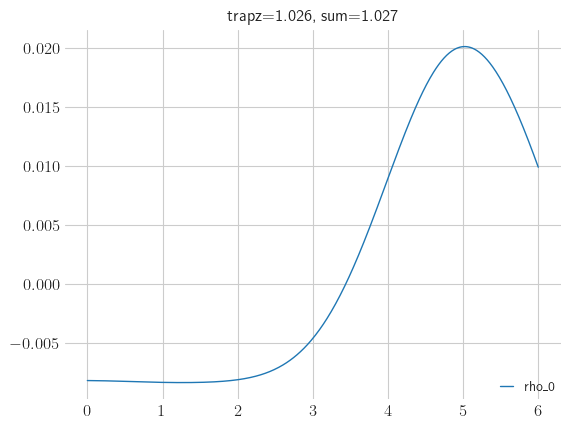

In [24]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

print(test_ti)

ind = np.lexsort((test_ti[:,EQ_IDX],test_ti[:,0])) # sorts by [1] (t) then by [3] (rho_0)
test_ti = test_ti[ind]

s1 = np.trapz(test_ti[:,EQ_IDX], axis=0)
s2 = np.sum(test_ti[:,EQ_IDX])

fig = plt.figure(1)
ax1 = plt.subplot(111, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('trapz=%.3f, sum=%.3f' % (s1, s2))

ax1.plot(
    test_ti[:, 0],
    test_ti[:, EQ_IDX],
    linewidth=1,
    label='rho_0')
ax1.legend(loc='lower right')

plt.show()

In [ ]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

ti_rho_opt = test_ti[:, ]

ti_rho_opt = np.where(ti_rho_opt<0, 0, ti_rho_opt)

ti_x1_x2_x3 = test_ti[:, 0:3]

####################################################################

d = 0.0
x1 = np.linspace(state_min - d, state_max + d, N)
x2 = np.linspace(state_min - d, state_max + d, N)
x3 = np.linspace(state_min - d, state_max + d, N)
X1, X2, X3 = np.meshgrid(x1,x2,x3,copy=False) # each is NxNxN

rho_opt = np.zeros((N,N,N))

closest_1 = [(np.abs(x1 - ti_x1_x2_x3[i, 0])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_2 = [(np.abs(x2 - ti_x1_x2_x3[i, 1])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_3 = [(np.abs(x3 - ti_x1_x2_x3[i, 2])).argmin() for i in range(ti_x1_x2_x3.shape[0])]

# some transposing going on in some reshape
# swapping closest_1/2 works well
rho_opt[closest_1, closest_2, closest_3] = ti_rho_opt

####################################################################

# RHO_OPT = gd(
#   (ti_x1_x2_x3[:, 0], ti_x1_x2_x3[:, 1], ti_x1_x2_x3[:, 2]),
#   ti_rho_opt,
#   (X1, X2, X3),
#   method='linear')

####################################################################

x1_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[j, i, :], x=x3) # x3 slices for one x2 => R
            for i in range(len(x2))]) # x3 slices across all x2 => Rn
        , x=x2) # x2 slice for one x1 => R
for j in range(len(x1))])

x2_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, j, :], x=x3) # x3 slices for one x1 => R
            for i in range(len(x1))]) # x3 slices across all x1 => Rn
        , x=x1) # x1 slice for one x2 => R
for j in range(len(x2))])

x3_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, :, j], x=x2) # x2 slices for one x1 => R
            for i in range(len(x1))]) # x2 slices across all x1 => Rn
        , x=x1) # x1 slice for one x3 => R
for j in range(len(x3))])

####################################################################

# normalize all the pdfs so area under curve ~= 1.0
x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("prior to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

x1_marginal /= x1_pdf_area
x2_marginal /= x2_pdf_area
x3_marginal /= x3_pdf_area

print(x1_marginal.shape)

x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("after to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

fig = plt.figure(1)
ax1 = plt.subplot(131, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('x1 marginal')

ax2 = plt.subplot(132, frameon=False)
# ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('x2 marginal')

# ax3 = plt.subplot(133, frameon=False)

ax3 = plt.subplot(133, frameon=False)
# ax3.set_aspect('equal')
ax3.grid()
ax3.set_title('x3 marginal')

colors="rgbymkc"

i = 0
t_e = 0
ax1.plot(x1,
    x1_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax1.legend(loc='lower right')

ax2.plot(x2,
    x2_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax2.legend(loc='lower right')

ax3.plot(x3,
    x3_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax3.legend(loc='lower right')

fig.suptitle('t=%.2f' % (target_t), fontsize=16)

plt.show()